# 1.

In [10]:
import os, csv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# -------------------------------------------
# Paths
# -------------------------------------------
airports_path = "data/airports_cleaned.csv"
routes_path = "data/routes_to_use.csv"

# -------------------------------------------
# Load airports
# -------------------------------------------
airport_cols = ["id", "name", "city", "country", "iata", "icao", "latitude", "longitude"]
airports = []

with open(airports_path, "r", encoding="utf-8", errors="replace") as f:
    reader = csv.DictReader(f)
    for row in reader:

        # Convert coordinates safely
        try:
            row["latitude"] = float(row["latitude"]) if row["latitude"] else None
        except:
            row["latitude"] = None

        try:
            row["longitude"] = float(row["longitude"]) if row["longitude"] else None
        except:
            row["longitude"] = None

        airports.append(row)

airports_df = pd.DataFrame(airports)

# Replace empty codes with NA
airports_df["iata"] = airports_df["iata"].replace({"": pd.NA})
airports_df["icao"] = airports_df["icao"].replace({"": pd.NA})

# Choose node key
def choose_key(row):
    if pd.notna(row["iata"]) and str(row["iata"]).strip() != "":
        return str(row["iata"]).strip()
    if pd.notna(row["icao"]) and str(row["icao"]).strip() != "":
        return str(row["icao"]).strip()
    return str(row["id"])

airports_df["node_key"] = airports_df.apply(choose_key, axis=1)

# -------------------------------------------
# Load routes
# -------------------------------------------
routes = []
with open(routes_path, "r", encoding="utf-8", errors="replace") as f:
    reader = csv.DictReader(f)
    for row in reader:
        row["src_airport"] = row["src_airport"].strip()
        row["dst_airport"] = row["dst_airport"].strip()
        routes.append(row)

routes_df = pd.DataFrame(routes)
routes_df = routes_df.rename(columns={"src_airport": "src", "dst_airport": "dst"})
routes_df = routes_df[routes_df["src"] != ""]


# 2.

In [11]:
# -------------------------------------------
# Build MultiDiGraph with parallel edges
# -------------------------------------------
G_multi = nx.MultiDiGraph()

for _, row in airports_df.iterrows():
    key = row["node_key"]
    G_multi.add_node(
        key,
        name=row["name"],
        city=row["city"],
        country=row["country"],
        iata=row["iata"],
        icao=row["icao"],
        lat=row["latitude"],
        lon=row["longitude"],
    )

missing_nodes = set()

# Add edges
for _, r in routes_df.iterrows():
    src, dst = r["src"], r["dst"]

    if src == "" or dst == "":
        continue

    if src not in G_multi:
        missing_nodes.add(src)
        G_multi.add_node(src, name=None, city=None, country=None,
                         iata=src, icao=None, lat=None, lon=None)

    if dst not in G_multi:
        missing_nodes.add(dst)
        G_multi.add_node(dst, name=None, city=None, country=None,
                         iata=dst, icao=None, lat=None, lon=None)

    G_multi.add_edge(src, dst, airline=r.get("airline"), equipment=r.get("equipment"))

# -------------------------------------------
# Condensed DiGraph (weighted)
# -------------------------------------------
G = nx.DiGraph()

for n, attrs in G_multi.nodes(data=True):
    G.add_node(n, **attrs)

for u, v, data in G_multi.edges(data=True):
    if G.has_edge(u, v):
        G[u][v]["weight"] += 1
    else:
        G.add_edge(u, v, weight=1)


# 3.

In [12]:
# -------------------------------------------
# Basic network statistics
# -------------------------------------------
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
num_multi_edges = G_multi.number_of_edges()
num_missing_nodes = len(missing_nodes)

in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

degree_df = pd.DataFrame({
    "node": list(G.nodes()),
    "in_degree": [in_degrees.get(n,0) for n in G.nodes()],
    "out_degree": [out_degrees.get(n,0) for n in G.nodes()],
    "lat": [G.nodes[n].get("lat") for n in G.nodes()],
    "lon": [G.nodes[n].get("lon") for n in G.nodes()],
    "name": [G.nodes[n].get("name") for n in G.nodes()],
    "country": [G.nodes[n].get("country") for n in G.nodes()]
})

degree_df["total_degree"] = degree_df["in_degree"] + degree_df["out_degree"]

top_hubs = degree_df.sort_values("total_degree", ascending=False).head(20).reset_index(drop=True)

# -------------------------------------------
# Betweenness Centrality
# -------------------------------------------
if num_nodes > 2000:
    bet = nx.betweenness_centrality(G, k=200, seed=42)
else:
    bet = nx.betweenness_centrality(G)

bet_df = pd.DataFrame([
    {"node": n, "betweenness": b,
     "in_degree": in_degrees.get(n,0),
     "out_degree": out_degrees.get(n,0)}
    for n, b in bet.items()
]).sort_values("betweenness", ascending=False).head(20)

# -------------------------------------------
# Undirected properties
# -------------------------------------------
UG = G.to_undirected()
num_cc = nx.number_connected_components(UG)
largest_cc = max(nx.connected_components(UG), key=len)
avg_clust = nx.average_clustering(UG)

UGC = UG.subgraph(largest_cc)
diameter = nx.diameter(UGC) if UGC.number_of_nodes() > 1 else 0


# 4.

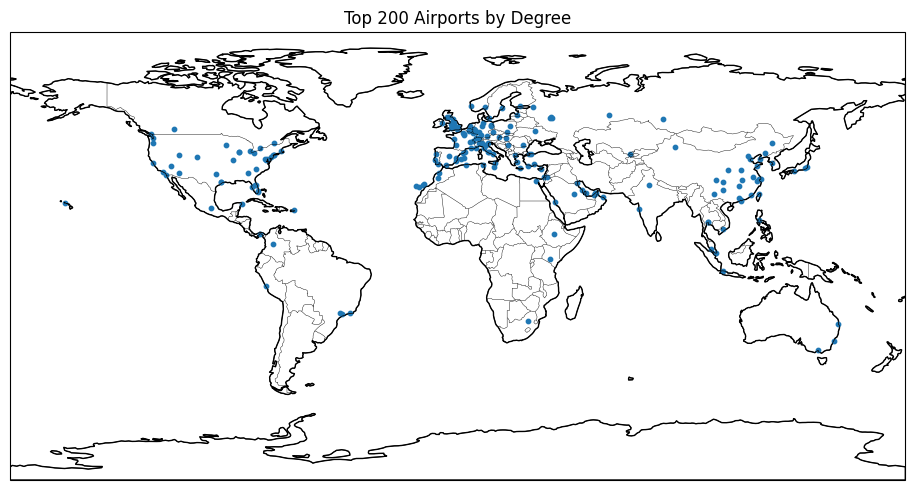

In [13]:
coords_df = degree_df.dropna(subset=["lat", "lon"])\
                     .sort_values("total_degree", ascending=False)\
                     .head(200)

fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor="none", edgecolor="black")
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)

ax.scatter(
    coords_df["lon"], coords_df["lat"],
    s=10, transform=ccrs.PlateCarree()
)

ax.set_global()
plt.title("Top 200 Airports by Degree")
plt.tight_layout()
plt.show()


# 5.

In [14]:
def largest_component_size(G):
    comp = max(nx.connected_components(G.to_undirected()), key=len)
    return len(comp)

original_lcc = largest_component_size(G)

top_airports = degree_df.sort_values("total_degree", ascending=False)

def remove_and_measure(G, k):
    G2 = G.copy()
    hubs = top_airports.index[:k]
    G2.remove_nodes_from(hubs)
    UG2 = G2.to_undirected()
    return largest_component_size(G2), nx.average_clustering(UG2)

for k in [1,5,10,25,50]:
    lcc, clust = remove_and_measure(G, k)
    print(f"Remove top {k} hubs → LCC = {lcc},  Avg clustering = {clust:.4f}")


Remove top 1 hubs → LCC = 3264,  Avg clustering = 0.2067
Remove top 5 hubs → LCC = 3264,  Avg clustering = 0.2067
Remove top 10 hubs → LCC = 3264,  Avg clustering = 0.2067
Remove top 25 hubs → LCC = 3264,  Avg clustering = 0.2067
Remove top 50 hubs → LCC = 3264,  Avg clustering = 0.2067


# 6.

In [16]:
from pathlib import Path
import folium
from folium.plugins import FastMarkerCluster

def build_map(show_airports=True, max_routes=100000, opacity=0.25, weight=1.0, gc_steps=0):
    """
    Build a Folium interactive map using the already-loaded airports_df and routes_df.
    This version does NOT rely on argparse; everything is passed as arguments.
    """

    # -----------------------------
    # Convert airports_df into dict
    # -----------------------------
    airports = {}
    for _, row in airports_df.iterrows():
        key = row["node_key"]
        airports[key] = (
            row["name"], row["city"], row["country"],
            row["latitude"], row["longitude"]
        )

    # -----------------------------
    # Convert routes_df into list
    # -----------------------------
    routes = [(row.src, row.dst) for _, row in routes_df.iterrows()]

    # -----------------------------
    # Create map base
    # -----------------------------
    m = folium.Map(
        location=[20, 0],
        zoom_start=2,
        tiles="https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png",
        attr="OpenStreetMap"
    )

    # -----------------------------
    # Optional: show airports
    # -----------------------------
    if show_airports:
        marker_points = []
        for key, (name, city, country, lat, lon) in airports.items():
            if pd.isna(lat) or pd.isna(lon):
                continue
            label = f"{name} — {city}, {country} ({key})"
            marker_points.append([lat, lon, label])

        FastMarkerCluster(
            data=[[lat, lon] for lat, lon, _ in marker_points],
            name="Airports",
            show=True
        ).add_to(m)

    # -----------------------------
    # Routes layer
    # -----------------------------
    routes_layer = folium.FeatureGroup(name="Routes", show=True)
    missing = 0

    for i, (src, dst) in enumerate(routes, 1):
        if src not in airports or dst not in airports:
            missing += 1
            continue

        _, _, _, lat1, lon1 = airports[src]
        _, _, _, lat2, lon2 = airports[dst]

        if pd.isna(lat1) or pd.isna(lon1) or pd.isna(lat2) or pd.isna(lon2):
            continue

        pts = gc_intermediate_points(lon1, lat1, lon2, lat2, steps=gc_steps)
        latlon = [(lat, lon) for lat, lon in pts]

        folium.PolyLine(
            latlon,
            weight=weight,
            opacity=opacity,
            tooltip=f"{src} → {dst}"
        ).add_to(routes_layer)

    routes_layer.add_to(m)
    folium.LayerControl(collapsed=False).add_to(m)

    return m
